### Imports

In [1]:
import os
os.chdir('../../')

from hydra import initialize, compose
from omegaconf import OmegaConf

import mlflow
import pickle
import pandas as pd
import numpy as np
import wordcloud
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

### Load Trained Model

In [2]:
with initialize(version_base=None, config_path='../../conf/'):
    cfg = compose(config_name='config')
cfg = cfg.test
print(cfg)

{'mlflow_dir': 'mlruns', 'mlflow_source_experiment_name': '220812_123209_q1_10000t_random', 'mlflow_run_id': '059651b7006d4e0099fdf410fad12532', 'test_path': '${split_train_test.test_path}', 'target_var': '${train.target_var}', 'invert_target': '${train.invert_target}', 'mlflow_target_experiment_name': '${train.target_var}_test'}


In [3]:
# Load the trained model
exper = mlflow.get_experiment_by_name(cfg.mlflow_source_experiment_name)
model_loc = f'{cfg.mlflow_dir}/{exper.experiment_id}/{cfg.mlflow_run_id}/artifacts/model/model.pkl'
with open(model_loc, 'rb') as f:
    mdl = pickle.load(f)

## ⚖️ Feature Weights

In [4]:
def get_feat_weights_df(mdl):
    coefs = mdl[-1].coef_.copy()
    feats = mdl[:-1].get_feature_names_out()
    fwdfs = [
        pd.DataFrame({
            'feature': [f.split('__')[1] for f in feats],
            'class': i,
            'coef': coefs[i, :]
        })
        for i in range(coefs.shape[0])
    ]
    fwdf = pd.concat(fwdfs, axis=0).sort_values(['class','feature']).set_index(['class','feature'])
    fwdf['abs'] = fwdf['coef'].abs()
    fwdf['pos'] = fwdf['coef'] >= 0
    return fwdf 

feat_weights = get_feat_weights_df(mdl)
# feat_weights = feat_weights.sort_values('coef')
# feat_weights = feat_weights.set_index('feature')

In [5]:
for c in feat_weights.index.levels[0]:
    # print(f'# Class {c}')
    # print()
    fwc = feat_weights.loc[c, :]
    print(f'Highest Weighted toward Q1 = {c}')
    print(fwc.sort_values('coef', ascending=False).head(10))
    print()

Highest Weighted toward Q1 = 0
                 coef       abs   pos
feature                              
supervision  0.191684  0.191684  True
nan          0.186632  0.186632  True
vec_67       0.177202  0.177202  True
application  0.176263  0.176263  True
vec_59       0.169847  0.169847  True
us           0.167294  0.167294  True
respiratory  0.167205  0.167205  True
vec_39       0.151067  0.151067  True
vec_63       0.144987  0.144987  True
strategy     0.144881  0.144881  True

Highest Weighted toward Q1 = 1
                   coef       abs   pos
feature                                
vec_70         0.210468  0.210468  True
management of  0.192973  0.192973  True
vec_6          0.177423  0.177423  True
vec_33         0.157488  0.157488  True
vec_89         0.141031  0.141031  True
vec_5          0.134107  0.134107  True
vec_64         0.130872  0.130872  True
vec_92         0.124444  0.124444  True
action         0.121806  0.121806  True
skill          0.116416  0.116416  True



In [11]:
feat_weights

### Words/Features Weighted *Toward* Q2 = 1

In [5]:
feat_weights.head(20)[['coef','coef.abs']]

,coef,coef.abs
feature,,
remember,-0.415952,0.415952
discussed,-0.341634,0.341634
continue,-0.256533,0.256533
consider,-0.241614,0.241614
use,-0.230815,0.230815
review,-0.205995,0.205995
approach,-0.199619,0.199619
bed,-0.188099,0.188099
suggest,-0.176640,0.176640


### Words/Features Weighted *Against* Q2 = 1

In [6]:
feat_weights.tail(20)[['coef','coef.abs']]

,coef,coef.abs
feature,,
management,0.105468,0.105468
vec_8,0.107362,0.107362
vec_58,0.107530,0.107530
managed,0.109791,0.109791
vec_66,0.111199,0.111199
department,0.113547,0.113547
received,0.115184,0.115184
excellent,0.120620,0.120620
presentation,0.120905,0.120905


## ⚖️ ➖ Feature Weights (vector features removed)

In [7]:
feat_weights = feat_weights.reset_index()
feat_weights = feat_weights[~feat_weights['feature'].str.contains('vec_')].set_index('feature')

### Words/Features Weighted *Toward* Q2 = 1

In [14]:
feat_weights.head(20)[['coef','coef.abs']]

,coef,coef.abs
feature,,
remember,-0.415952,0.415952
discussed,-0.341634,0.341634
continue,-0.256533,0.256533
consider,-0.241614,0.241614
use,-0.230815,0.230815
review,-0.205995,0.205995
approach,-0.199619,0.199619
bed,-0.188099,0.188099
suggest,-0.176640,0.176640


### Words/Features Weighted *Against* Q2 = 1

In [15]:
feat_weights.tail(20)[['coef','coef.abs']]

,coef,coef.abs
feature,,
level training,0.089348,0.089348
patient required,0.091361,0.091361
challenging,0.091710,0.091710
manage,0.094978,0.094978
sats,0.096159,0.096159
possible,0.100665,0.100665
trainee able,0.102471,0.102471
arranged,0.103257,0.103257
management,0.105468,0.105468


## ☁️ Word Clouds

### All Words

Red means the word is weighted *toward* Q2 = 0

Green means the word is weighted *against* Q2 = 1

In [10]:
def color_func(word, *args, **kwargs):
    if not feat_weights.loc[word, 'positive']: return (60, 186, 72)
    else: return (186, 60, 60)

(-0.5, 799.5, 399.5, -0.5)

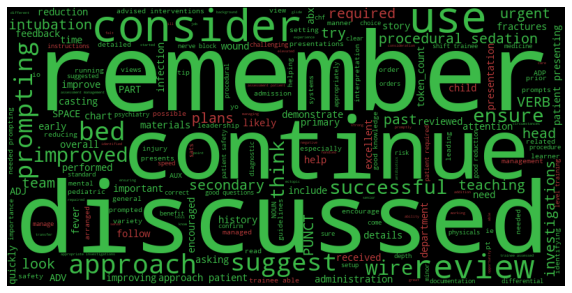

In [11]:
fw_for_wc = feat_weights[['coef.abs']].to_dict()['coef.abs']
wc = wordcloud.WordCloud(width=800, height=400, color_func=color_func)
wc = wc.fit_words(fw_for_wc)
plt.figure(figsize=(10,20))
plt.imshow(wc)
plt.axis('off')

### Wordcloud -  Words Weighted *Toward* Q2 = 1

(-0.5, 799.5, 399.5, -0.5)

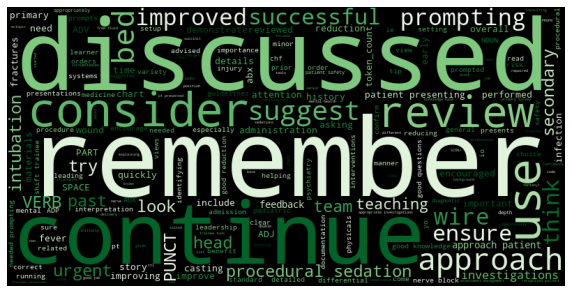

In [12]:
fw_for_wc = feat_weights[feat_weights['coef'] < 0][['coef.abs']].to_dict()['coef.abs']
wc = wordcloud.WordCloud(width=800, height=400, colormap=get_cmap('Greens'))
wc = wc.fit_words(fw_for_wc)
plt.figure(figsize=(10,20))
plt.imshow(wc)
plt.axis('off')

### Wordcloud -  Words Weighted *Against* Q2 = 1

(-0.5, 799.5, 399.5, -0.5)

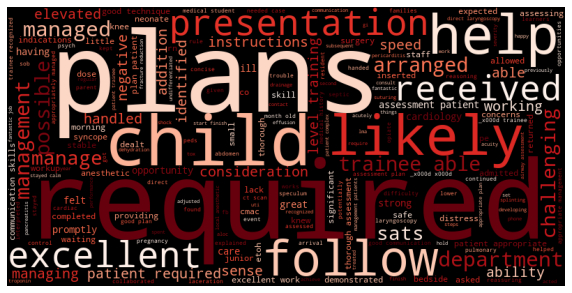

In [13]:
fw_for_wc = feat_weights[feat_weights['coef'] >= 0][['coef.abs']].to_dict()['coef.abs']
wc = wordcloud.WordCloud(width=800, height=400, colormap=get_cmap('Reds'))
wc = wc.fit_words(fw_for_wc)
plt.figure(figsize=(10,20))
plt.imshow(wc)
plt.axis('off')